In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [15]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [16]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

In [17]:
df = read_csv_replace_missing_by_polynomial('piaui_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2005,0.000000,1002.913062,433.322715,28.538126,21.973058,70.020310,1.506951
1,2005,0.000000,1002.947677,433.322715,28.749664,21.830750,68.328002,1.541567
2,2005,0.000000,1002.981011,433.322715,28.953368,21.693713,66.698372,1.574900
3,2005,0.000000,1003.013154,433.322715,29.149797,21.561571,65.126944,1.607043
4,2005,0.000000,1003.044188,433.322715,29.339452,21.433984,63.609702,1.638077
...,...,...,...,...,...,...,...,...
211,2022,2.257956,1002.683043,1216.674263,27.978726,20.392056,67.226142,1.172788
212,2022,2.315055,1002.629161,1210.765188,27.999911,20.495779,67.491648,1.170616
213,2022,2.261870,1002.606551,1201.422191,27.966407,20.578562,67.880521,1.164112
214,2022,2.326006,1002.640215,1191.932017,27.894539,20.648122,68.348892,1.153561


In [18]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2005,0.670655,1002.887062,476.142629,29.672701,21.676761,62.767848,1.632847
2006,8.735503,1002.694409,711.371708,30.249188,21.808434,59.545395,1.614053
2007,18.226148,1002.224735,1071.419602,29.390926,21.464681,62.633030,1.455016
2008,24.296582,1002.253734,1279.489487,28.374914,21.343931,67.378713,1.314599
2009,23.274048,1002.162518,1397.889138,27.971629,21.269184,69.377054,1.242652
2010,19.182853,1002.283003,1437.681759,27.813041,21.237580,70.062576,1.227247
2011,18.107389,1002.395371,1443.014477,27.920185,21.009865,69.079510,1.247622
2012,18.252844,1002.464093,1406.026571,27.983708,20.651339,67.998886,1.231493
2013,18.670752,1002.768122,1348.345803,27.951493,20.492168,67.705538,1.231771


In [19]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,18.366943,1002.930152,1312.189559,28.101214,20.242493,66.500996,1.263497
2015,19.175926,1002.890504,1261.987570,28.208348,20.043769,65.528148,1.276249
2016,22.137114,1002.832338,1235.205362,28.178052,20.095966,65.401854,1.267215
2017,24.264986,1002.920008,1214.156503,28.068432,20.444122,66.544636,1.228392
2018,22.693879,1002.983523,1225.305663,28.124040,20.588603,66.918659,1.220562
2019,20.177485,1002.894000,1274.660123,28.368985,20.453014,65.900441,1.237508
2020,23.289184,1002.778124,1246.811836,28.287959,20.572557,66.685432,1.202091
2021,27.122721,1002.720249,1192.333102,27.966206,20.640074,68.083428,1.160211
2022,26.884797,1002.715696,1195.956002,27.902157,20.532018,67.970748,1.160725


In [20]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

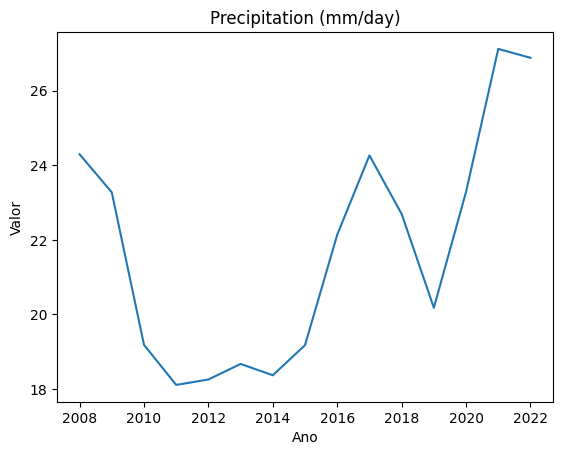

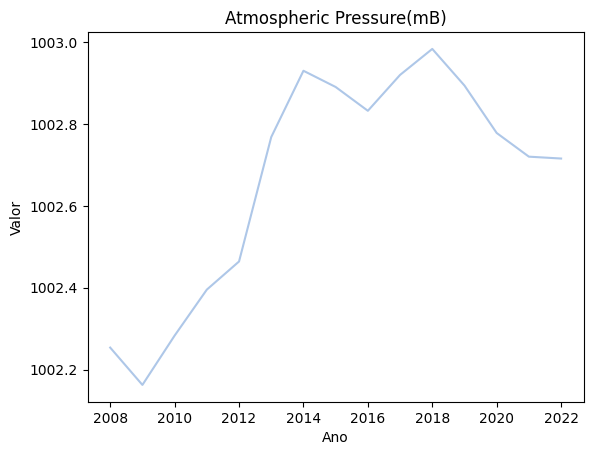

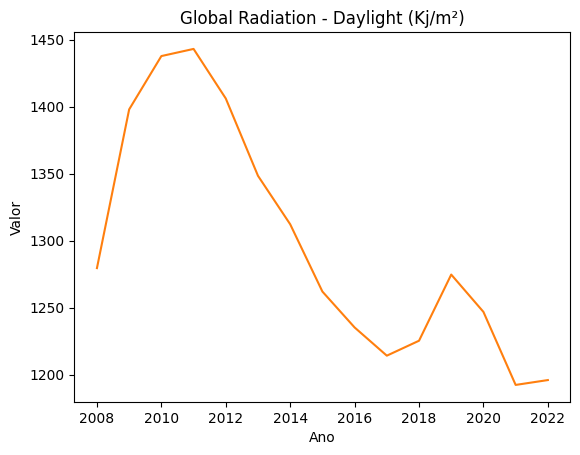

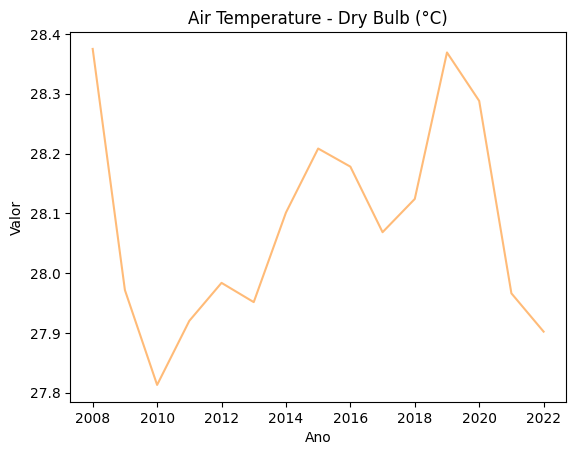

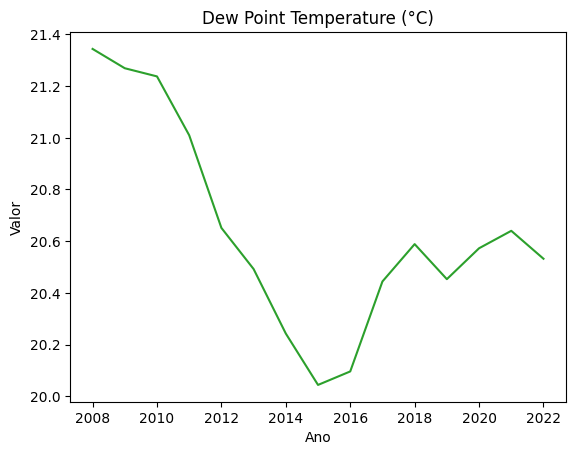

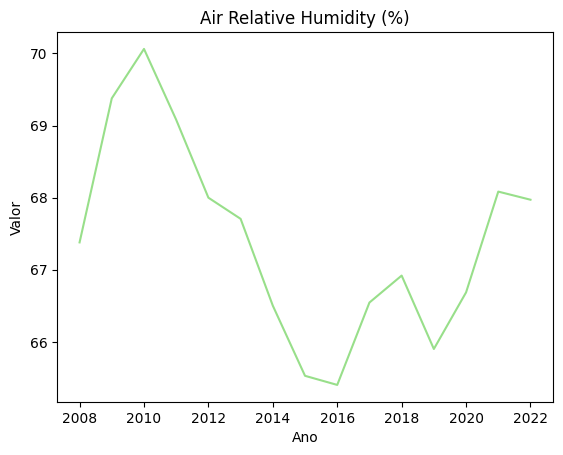

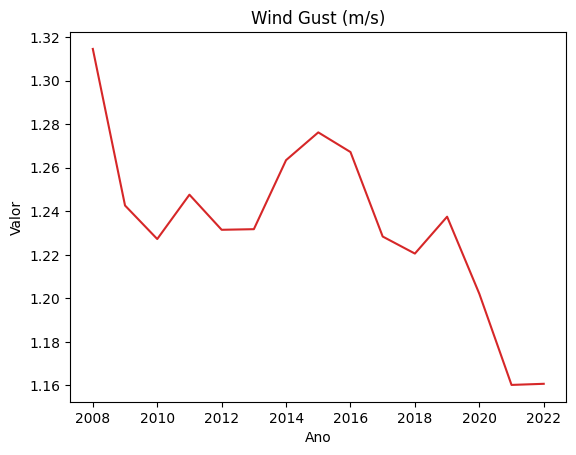

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,24.296582,1002.253734,1279.489487,28.374914,21.343931,67.378713,1.314599
2009,23.274048,1002.162518,1397.889138,27.971629,21.269184,69.377054,1.242652
2010,19.182853,1002.283003,1437.681759,27.813041,21.237580,70.062576,1.227247
2011,18.107389,1002.395371,1443.014477,27.920185,21.009865,69.079510,1.247622
2012,18.252844,1002.464093,1406.026571,27.983708,20.651339,67.998886,1.231493
2013,18.670752,1002.768122,1348.345803,27.951493,20.492168,67.705538,1.231771
2014,18.366943,1002.930152,1312.189559,28.101214,20.242493,66.500996,1.263497
2015,19.175926,1002.890504,1261.987570,28.208348,20.043769,65.528148,1.276249
2016,22.137114,1002.832338,1235.205362,28.178052,20.095966,65.401854,1.267215


In [21]:
df_2008 = df_year[df_year.index >= 2008]
plot_columns(df_2008)
df_2008

In [22]:
df_2008.to_csv('2008_01_meteo.csv', index=True)